Image Processing
================


This notebook shows examples of using `aotools` to do the following:
- Measure properties of point sources
- Measure properties of extended sources


In [1]:
import numpy
import matplotlib.pylab as plt
from tqdm import tqdm, trange, tqdm_notebook
from astropy.io import fits
# %matplotlib inline
import aotools
from aotools.turbulence import phasescreen, infinitephasescreen
from matplotlib import animation, rc, rcParams
from IPython.display import HTML
import matplotlib.colors as colors

rcParams['figure.figsize'] = [10,5]

import scipy.signal
j = 0+1j

Measuring the Position of a Point Source
----------------------------------------

First we need to create our PSF. To do this we are going to simply take our aperture function example from the previous notebook. 

In [2]:
# Set up parameters for creating phase screens
nx_size = 64 # pxls
D = 0.5 # m
pxl_scale = D/nx_size # m/pxl
pad_factor = 2
r0 = 0.16 # m
L0 = 10 # m
l0 = 1e-3 # m
wavelength = 500e-9 # m

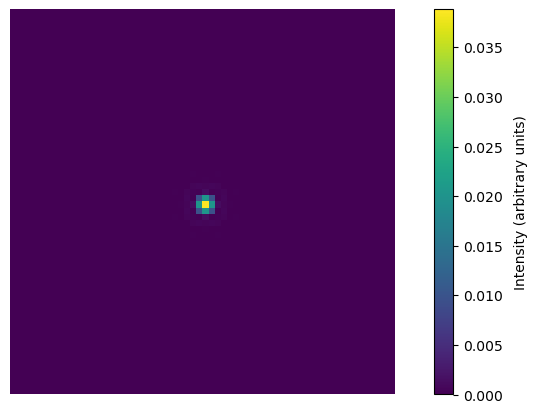

In [3]:
pupil = aotools.circle(D/pxl_scale/2, nx_size)
# pupil = numpy.ones((nx_size, nx_size))

pad_size = nx_size*pad_factor
padded_pupil = numpy.zeros((pad_size, pad_size))
padded_pupil[:nx_size, :nx_size] = pupil

# Use AOtools to transform from the pupil to the focal plane
psf = numpy.abs(aotools.ft2(padded_pupil, delta=pxl_scale,)**2.)

psf_cut= psf[int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2), int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2)]

plt.figure()
plt.imshow(psf_cut)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)

To measure the position of this PSF we can "centroid" it using any number of different techniques. The simplist is a centre of gravity, and can be used:

In [4]:
centroid = aotools.centre_of_gravity(psf)
print(centroid)

[64. 64.]


This gives us the position of the PSF, in our example using 64 x 64 pixel pupil with a factor of 2 oversampling (128 x 128) the PSF is centred, so the `centre_of_gravity` method returns the pixel position of the centre.

(-0.5, 63.5, 63.5, -0.5)

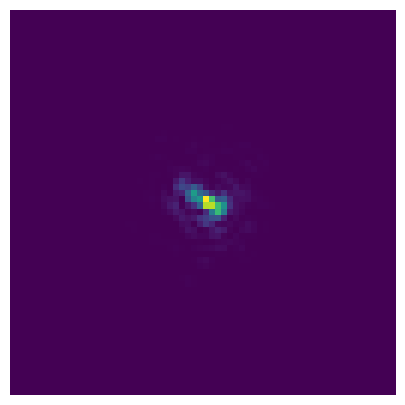

In [5]:
# Create the phase screen object using aotools
phase_screen = phasescreen.ft_phase_screen(r0, pad_size, pxl_scale, L0, l0)
complex_field = padded_pupil * numpy.exp(j*phase_screen)

# Use AOtools to transform from the pupil to the focal plane
psf = numpy.abs(aotools.ft2(complex_field, delta=pxl_scale,)**2.)

psf_cut= psf[int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2), int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2)]

# Plot the PSF
plt.figure()
plt.imshow(psf_cut)
plt.axis('off')


In [6]:
centroid = aotools.centre_of_gravity(psf)
print(centroid)

[64.2102524  63.54097328]


The PSF has moved. Note that the units here are pixels, and needs to be converted to the physical simulation units (_e.g._ arcseconds). This is done using the formula to convert from real space pixel scale to Fourier space pixel scale, but also multiplying by the imaging wavelength $\lambda$:
$$ \delta_\theta = \frac{\lambda}{N \delta_x}$$
This gives the pixel scale in radians in the focal plane.

C:\Users\fddj2\AppData\Local\Temp\ipykernel_20808\542533522.py:16: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  psf_centroid.set_data(0,0)


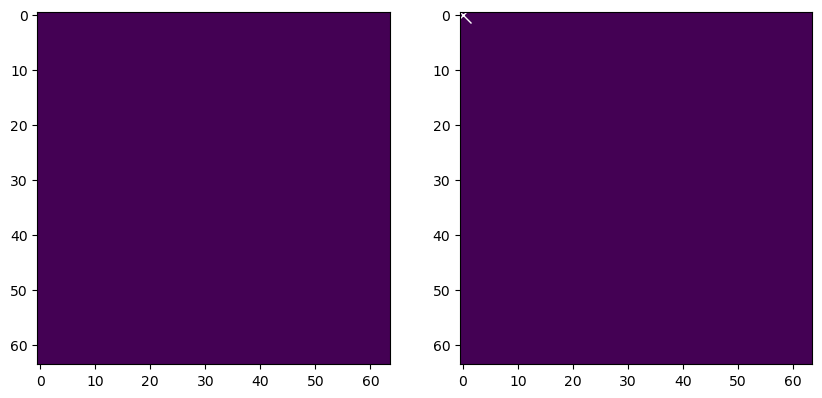

In [7]:
frames=500

phase_screen = infinitephasescreen.PhaseScreenKolmogorov(nx_size, pxl_scale, r0, L0)
padded_pupil = numpy.zeros((nx_size*pad_factor, nx_size*pad_factor), dtype=numpy.complex64)
psfs = numpy.zeros((frames, nx_size*pad_factor, nx_size*pad_factor))

# Video of moving a phase screen and PSF
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
screen_image = ax1.imshow(numpy.zeros((nx_size, nx_size)))
psf_image = ax2.imshow(numpy.zeros((nx_size, nx_size)))
psf_centroid = ax2.plot(0,0, color='w', marker='x', markersize=12)[0]

def init():
    screen_image.set_data(numpy.zeros((nx_size, nx_size)))
    psf_image.set_data(numpy.zeros((nx_size, nx_size)))
    psf_centroid.set_data(0,0)
    return (screen_image, psf_image, psf_centroid,)

def animate(i):  
    phase_screen.add_row()
    wavefront = numpy.copy(phase_screen.scrn)
    screen_image.set_data(wavefront*aotools.circle(nx_size/2, nx_size))
    screen_image.autoscale()
    
    padded_pupil[:nx_size, :nx_size] = pupil * numpy.exp(j*wavefront)
    
    # Use AOtools to transform from the pupil to the focal plane
    psf = numpy.abs(aotools.ft2(padded_pupil, delta=pxl_scale))**2.
    
    psf_cut = psf[int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2), int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2)]
    
    psf_image.set_data(psf_cut)
    psf_image.autoscale()
    
    psf_centroid.set_data(aotools.centre_of_gravity(psf_cut))
    
    return (screen_image, psf_image, psf_centroid)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=10, 
                               blit=True)

In [ ]:
HTML(anim.to_html5_video())

C:\Users\fddj2\AppData\Local\Temp\ipykernel_20808\542533522.py:16: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  psf_centroid.set_data(0,0)
C:\Users\fddj2\AppData\Local\Temp\ipykernel_20808\542533522.py:35: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  psf_centroid.set_data(aotools.centre_of_gravity(psf_cut))


Now you have all the tools and knowledge to make your own Shack-Hartmann wavefront sensor, and the ability to process the images produced by it.

> HINT: A Shack-Hartmann is essentially a grid placed across a pupil, with each "box" forming its own imaging system.